In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


In [3]:
import math
import os
import pickle
import random
from datetime import datetime

import numpy as np
import torch
from matplotlib import pyplot as plt
from music21 import converter
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from IPython.display import display, Audio

from utils import decode_midi

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [5]:
torch.manual_seed(0);

## Data processing

In [6]:
DATA_ROOT = "data/pop_pickle"
N_SAMPLES = 909
VOCAB_SIZE = 390
BOS_TOKEN = VOCAB_SIZE - 2
PAD_TOKEN = VOCAB_SIZE - 1

In [7]:
dataset = []
for i in range(N_SAMPLES):
    file_name = str(i + 1).zfill(3) + ".pickle"
    path = os.path.join(DATA_ROOT, file_name)
    with open(path, "rb") as f:
        seq = pickle.load(f)
        seq_tensor = torch.LongTensor(seq)
    dataset.append(seq_tensor)

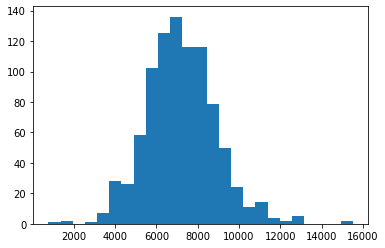

In [8]:
seq_lens = [len(seq) for seq in dataset]

plt.figure()
plt.hist(seq_lens, bins=25)
plt.show()

In [181]:
N_VAL = N_TEST = int(0.05 * 909)
N_TRAIN = 909 - (N_VAL + N_TEST)

train_songs = dataset[:N_TRAIN]
val_songs = dataset[N_TRAIN:N_TRAIN+N_VAL]
test_songs = dataset[N_TRAIN+N_VAL:]

print(f"Train: {len(train_songs)} \t Val: {len(val_songs)} \t Test: {len(test_songs)}")

Train: 819 	 Val: 45 	 Test: 45


In [10]:
def batchify(seq, new_seq_len):
    """
    Convert a sequence into a batch of equal-length sequences,
    and prepend a BOS token at the start of every sequence.
    
    Unless new_seq_len perfectly divides the number of tokens
    in seq, the last sequence will be padded with PAD_TOKENs.
    """
    n = seq.numel() % new_seq_len
    pad_size = 0 if n == 0 else new_seq_len - n
    pad = torch.full(size=(pad_size,), fill_value=PAD_TOKEN)
    seq = torch.cat([seq, pad])
    assert seq.numel() % new_seq_len == 0
    num_batches = int(seq.numel() / new_seq_len)
    batch = seq.view(num_batches, -1)
    bos = torch.full(size=(num_batches, 1), fill_value=BOS_TOKEN)
    batch = torch.cat([bos, batch], dim=1)    
    return batch

In [11]:
SEQ_LEN = 1024

train_data = torch.cat([batchify(seq, SEQ_LEN) for seq in train_songs])
val_data = torch.cat([batchify(seq, SEQ_LEN) for seq in val_songs])
test_data = torch.cat([batchify(seq, SEQ_LEN) for seq in test_songs])

print(f"Train: {len(train_data)} \t Val: {len(val_data)} \t Test: {len(test_data)}")

Train: 6166 	 Val: 355 	 Test: 336


## Training the initial model

In [150]:
class MusicRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, rnn_type="lstm", num_layers=1, dropout=0.0):
        assert rnn_type in ["lstm", "gru"]

        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.dropout = dropout

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True) 
        else:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
        self.hidden_state = None

    def forward(self, x, reset_hidden_state=True):
        x = self.embeddings(x)
        if reset_hidden_state:
            x, _ = self.rnn(x)
        else:
            x, self.hidden_state = self.rnn(x, self.hidden_state)
        x = self.fc(x)
        return x

    def generate_sequence(self, seq_start=None, max_length=1024, **kwargs):
        if not seq_start:
            seq_start = [BOS_TOKEN]
        seq = seq_start.copy()
        with torch.no_grad():
            next_token = self._generate_next_token(
                next_input=torch.LongTensor(seq).to(device),
                reset_hidden=True,
                **kwargs
            )
            while len(seq) <= max_length:
                next_token = self._generate_next_token(
                    next_input=torch.LongTensor([next_token]).to(device),
                    reset_hidden=False,
                    **kwargs
                )
                seq.append(next_token)
        return seq
    
    def _generate_next_token(self, next_input, reset_hidden=False, temp=1.0, topk=5, argmax=False):
        # The model expects a batch input, so we add a fake batch dimension.
        model_input = next_input.unsqueeze(0)
        # Then, we need to remove the fake batch dimension from the output.
        model_output = self(model_input, reset_hidden).squeeze(0)
        next_token_probs = F.softmax(model_output[-1] / temp, dim=0)
        if argmax:
            next_token = torch.argmax(next_token_probs)
        else:
            top_tokens = torch.topk(next_token_probs, topk)
            top_indices = top_tokens.indices
            top_probs = top_tokens.values
            top_probs /= torch.sum(top_probs)
            next_token = np.random.choice(top_indices.cpu().numpy(), p=top_probs.cpu().numpy())
        return next_token.item()

In [179]:
def validate(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for batch in data_loader:
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            y_hat = model(x)
            y_hat = y_hat.transpose(1, 2)
            loss = loss_function(y_hat, y)
            total_loss += loss.item()
        ppl = math.exp(total_loss / len(data_loader))
        return ppl

def remove_special_tokens(seq):
    return [token for token in seq if token not in [BOS_TOKEN, PAD_TOKEN]]

def display_audio(seq):
    seq = remove_special_tokens(seq)
    decode_midi(seq, "data/music_out/tmp.mid")
    stream = converter.parse("data/music_out/tmp.mid")
    stream.show("midi")

In [153]:
NUM_LAYERS = 2
EMBEDDING_DIM = 64
HIDDEN_DIM = 256
NUM_EPOCHS = 250
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
CLIPPING_THRESHOLD = 1.0
DROPOUT = 0.5

LOG_EVERY_N = 1
VAL_EVERY_N = 10
SAVE_EVERY_N = 10

In [154]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=torch.stack,
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=torch.stack,
)

In [155]:
model = MusicRNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [156]:
print(model)

MusicRNN(
  (embeddings): Embedding(390, 64)
  (rnn): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=390, bias=True)
)


In [157]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")
exp_name = (
    f"{model.rnn_type}({EMBEDDING_DIM},{HIDDEN_DIM}),"
    f"lr={LEARNING_RATE},bsz={BATCH_SIZE},nepochs={NUM_EPOCHS},"
    f"sl={SEQ_LEN},dropout={DROPOUT},t={now}"
)
writer = SummaryWriter(f"runs/{exp_name}")

In [ ]:
for epoch in trange(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        # Move to GPU if available.
        batch = batch.to(device)

        # Reset gradients.
        model.zero_grad()

        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]
                
        # Forward prop.
        y_hat = model(x)
        
        # Swap token dim and output dim.
        y_hat = y_hat.transpose(1, 2)
        
        # Compute loss.
        loss = loss_function(y_hat, y)
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Clip gradients.
        clip_grad_norm_(model.parameters(), CLIPPING_THRESHOLD)
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
        
        train_ppl = math.exp(avg_loss)
        writer.add_scalar("train_ppl", train_ppl, global_step=epoch)

    if epoch % VAL_EVERY_N == 0:
        val_ppl = validate(model, val_loader)
        writer.add_scalar("val_ppl", val_ppl, global_step=epoch)
        generate_sequence(model, temp=1.0, topk=32);

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, f"models/ckpt_{epoch}.pt")

temp=1.0, topk=32


argmax=True


temp=1.0, topk=32


argmax=True


## Generating music

First, let's generate some music from scratch.

In [188]:
seq = model.generate_sequence(temp=1.0, topk=32)
display_audio(seq)

Next, let's use a priming sequence from our test set.

In [187]:
FIRST_N = 400

primer = test_songs[-1][:FIRST_N].tolist()
display_audio(primer)

In [195]:
continuation = model.generate_sequence(primer, temp=1.0, topk=128)
display_audio(continuation)